In [15]:
import osmnx as ox
import geopandas as gpd
from neo4j import GraphDatabase
import networkx as nx 
from geopy.distance import geodesic
import folium
import requests  
import webbrowser

In [16]:
# Spécifiez le nom de l'endroit
place_name = "Fès, Morocco"

# Télécharger les données du graphe de la ville de Fès, Maroc
graph = ox.graph_from_place(place_name, network_type="drive")

C:\Users\aya\AppData\Local\Temp\ipykernel_21052\3334448148.py:2: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_place(place_name, tags={'amenity': 'pharmacy'})


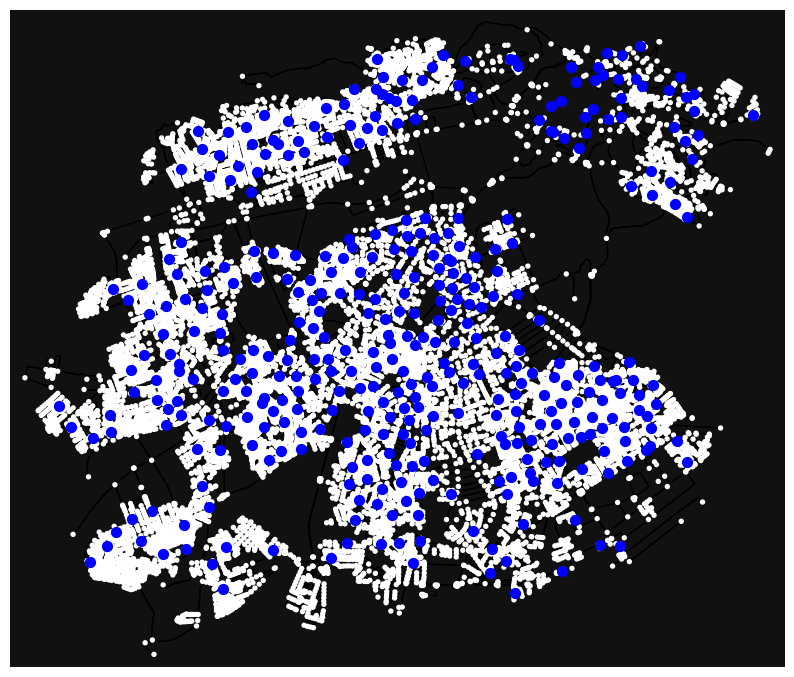

In [17]:
# Extraire tous les points d'intérêt (POI) de la ville de Fès pour les pharmacies
pois = ox.geometries_from_place(place_name, tags={'amenity': 'pharmacy'})

# Filtrer les géométries pour ne conserver que celles de type Point
pharmacies_gdf = gpd.GeoDataFrame(pois[pois.geometry.type == 'Point'])

# Afficher la carte de Fès
fig, ax = ox.plot_graph(graph, figsize=(10, 10), show=False, close=False, edge_color='k', node_color='w')

# Ajouter les pharmacies à la carte
ax.scatter(pharmacies_gdf['geometry'].x, pharmacies_gdf['geometry'].y, color='blue', s=50, label='Pharmacies')

In [18]:
# Afficher les noms des hôtels sous forme de liste
print("Liste des pharmacies à Fès, Maroc:")
for pharmacies_name in pharmacies_gdf['name'].unique():
    print("- ", pharmacies_name)

Liste des pharmacies à Fès, Maroc:
-  Pharmacie Centrale الصيدلية المركزية
-  Pharmacie Filali صيدلية فيلالي
-  Pharmacie Rcif صيدلية الرصيف
-  Pharmacie Irchad صيدلية إرشاد
-  Pharmacie Basmati صيدلية بسمتي
-  Pharmacie Lablida صيدلية البليدة
-  Pharmacie la Tulipe صيدلية لاتوليب
-  Pharmacie de la Liberté صيدلية الحرية
-  Pharmacie les Palmiers صيدلية النخيل
-  Pharmacie de France صيدلية فرنسا
-  Pharmacie l'Amitié صيدلية الصداقة
-  Pharmacie Bouslikhane صيدلية بوسليخن
-  Pharmacie Acima صيدلية أسيما
-  Pharmacie Echadli صيدلية الشادلي
-  Pharmacie Allal Ben Abdellah صيدلية علال بن عبد الله
-  Pharmacie du Maroc صيدلية المغرب
-  Pharmacie la Criée صيدلية المزاد
-  Pharmacie Bahja صيدلية البهجة
-  Pharmacie de la Santé صيدلية الصحة
-  Pharmacie Idrissi صيدلية الإدريسي
-  Pharmacie Debbagh صيدلية الدباغ
-  Pharmacie et Laboratoire Al Amrani صيدلية و مختبر العمراني
-  Pharmacie Moulay El Kamel صيدلية مولاي الكامل
-  Pharmacie Mimousa صيدلية ميموزة
-  Pharmacie Zemmouri صيدلية الزموري
- 

# Insertion des Pharmacies dans Neo4j

In [19]:
# Fonction pour établir une connexion à la base de données Neo4j
def connect_to_neo4j(uri, user, password):
    return GraphDatabase.driver(uri, auth=(user, password))

# Spécifiez les informations de connexion à votre base de données Neo4j
uri = "bolt://localhost:7687"
user = "neo4j"
password = "123456789"

# Établissez une connexion à la base de données Neo4j
driver = connect_to_neo4j(uri, user, password)

In [20]:
# Définissez une fonction pour insérer les données des pharmacies dans Neo4j
def insert_pharmacies_to_neo4j(pharmacies_gdf):
    with driver.session() as session:
        # Supprimez d'abord toutes les pharmacies existantes
        session.run("MATCH (p:Pharmacie) DETACH DELETE p")
        
        # Insérez les nouvelles pharmacies
        for idx, row in pharmacies_gdf.iterrows():
            cypher_query = (
                "CREATE (p:Pharmacie {id: $id, name: $name, latitude: $latitude, longitude: $longitude})"
            )
            session.run(cypher_query, id=str(idx), name=row.get('name', f'Pharmacie {idx}'), latitude=row['geometry'].y, longitude=row['geometry'].x)

# Utilisation de la fonction pour insérer les pharmacies et la localisation dans Neo4j
insert_pharmacies_to_neo4j(pharmacies_gdf)

print("Les données des pharmacies ont été insérées dans Neo4j avec succès.")

Les données des pharmacies ont été insérées dans Neo4j avec succès.


In [23]:
import geocoder
def get_current_location():
    # Utilisez la fonction ip() pour obtenir l'emplacement basé sur votre adresse IP
    location = geocoder.ip('me')
    return location.latlng  # Renvoie une liste contenant la latitude et la longitude

current_location = get_current_location()
if current_location:
    latitude, longitude = current_location

latitude,longitude

(34.0331, -5.0003)

# Insérer la localisation actuelle dans Neo4j

In [24]:
#current_location = {"latitude": latitude, "longitude": longitude}
# Fonction pour insérer la localisation dans Neo4j
def insert_location_to_neo4j(current_location):
    with driver.session() as session:
        # Supprimez d'abord tous les emplacements existants
        session.run("MATCH (l:Location) DETACH DELETE l")
        # Insérez la localisation dans la base de données
        session.run("CREATE (l:Location {latitude: $latitude, longitude: $longitude})", 
                    latitude=current_location[0], longitude=current_location[1])

# Définition de la localisation actuelle
current_location = (34.034589672957686, -4.9759245423286735)

# Utilisation de la fonction pour insérer la localisation dans Neo4j
insert_location_to_neo4j(current_location)

print("La localisation a été insérée dans Neo4j avec succès.")

La localisation a été insérée dans Neo4j avec succès.


In [ ]:
# Fonction pour calculer la distance entre deux points
def calculate_distance(lat1, lon1, lat2, lon2):
    return geodesic((lat1, lon1), (lat2, lon2)).kilometers

# Fonction pour créer des relations ROAD entre les pharmacies
def create_road_relations(driver, max_distance=0.5):
    with driver.session() as session:
        # Récupérer toutes les pharmacies
        pharmacies = session.run("MATCH (p:Pharmacie) RETURN p.id as id, p.latitude as latitude, p.longitude as longitude").data()
        
        # Créer des relations ROAD entre les pharmacies à moins de max_distance km l'une de l'autre
        for i in range(len(pharmacies)):
            for j in range(i+1, len(pharmacies)):
                distance = calculate_distance(pharmacies[i]['latitude'], pharmacies[i]['longitude'],
                                              pharmacies[j]['latitude'], pharmacies[j]['longitude'])
                if distance <= max_distance:
                    session.run("MATCH (p1:Pharmacie {id: $id1}), (p2:Pharmacie {id: $id2}) "
                                "CREATE (p1)-[:ROAD {distance: $distance}]->(p2)",
                                id1=pharmacies[i]['id'], id2=pharmacies[j]['id'], distance=distance)

# Appel de la fonction pour créer les relations ROAD
create_road_relations(driver)

# Trouver la pharmacie la plus proche avec la requête Cypher

In [ ]:
# Fonction pour trouver la pharmacie la plus proche
def find_nearest_pharmacy():
    query = """
    MATCH (l:Location), (p:Pharmacie)
    WITH l, p,
    point.distance(point({latitude: l.latitude, longitude: l.longitude}), point({latitude: p.latitude, longitude: p.longitude})) AS dist
    RETURN p.id AS id, p.name AS name, dist
    ORDER BY dist ASC
    LIMIT 1
    """
    with driver.session() as session:
        result = session.run(query).single()
        return result['id'], result['name'], result['dist']

nearest_pharmacy_id, nearest_pharmacy_name, nearest_pharmacy_distance = find_nearest_pharmacy()
print(f"La pharmacie la plus proche est {nearest_pharmacy_name} avec une distance de {nearest_pharmacy_distance:.2f} m")

# Créer une relation entre la localisation courante et la pharmacie la plus proche

In [28]:
# Fonction pour créer une relation entre la localisation courante et la pharmacie la plus proche
def create_nearest_pharmacy_relation(nearest_pharmacy_id, distance):
    query = """
    MATCH (l:Location), (p:Pharmacie {id: $id})
    CREATE (l)-[:NEAR {distance: $distance}]->(p)
    """
    with driver.session() as session:
        session.run(query, id=nearest_pharmacy_id, distance=distance)

create_nearest_pharmacy_relation(nearest_pharmacy_id, nearest_pharmacy_distance)
print(f"Relation créée entre la localisation courante et la pharmacie {nearest_pharmacy_name}.")

Relation créée entre la localisation courante et la pharmacie Pharmacie Youssra صيدلية يسرى.


In [29]:
# Fonction pour trouver la localisation courante et la pharmacie la plus proche
def get_current_location_and_nearest_pharmacy():
    query = """
    MATCH (l:Location)
    OPTIONAL MATCH (l)-[r:NEAR]->(p:Pharmacie)
    RETURN l.latitude AS current_latitude, l.longitude AS current_longitude, p.id AS pharmacy_id, p.latitude AS pharmacy_latitude, p.longitude AS pharmacy_longitude
    """
    with driver.session() as session:
        result = session.run(query).single()
        return result

result = get_current_location_and_nearest_pharmacy()
current_latitude = result['current_latitude']
current_longitude = result['current_longitude']
pharmacy_latitude = result['pharmacy_latitude']
pharmacy_longitude = result['pharmacy_longitude']

print(f"Current location: {current_latitude}, {current_longitude}")
print(f"Nearest pharmacy: {pharmacy_latitude}, {pharmacy_longitude}")

Current location: 34.034589672957686, -4.9759245423286735
Nearest pharmacy: 34.0293711, -4.9818124


In [42]:
# Fonction pour trouver la pharmacie la plus proche
def find_nearest_pharmacy():
    query = """
    MATCH (l:Location), (p:Pharmacie)
    WITH l, p,
    point.distance(point({latitude: l.latitude, longitude: l.longitude}), point({latitude: p.latitude, longitude: p.longitude})) AS dist
    RETURN p.id AS id, p.name AS name, p.latitude AS latitude, p.longitude AS longitude, dist
    ORDER BY dist ASC
    LIMIT 1
    """
    with driver.session() as session:
        result = session.run(query).single()
        if result:
            return {
                'id': result['id'],
                'name': result['name'],
                'latitude': result['latitude'],
                'longitude': result['longitude'],
                'distance': result['dist']
            }
        else:
            return None

# Utilisation de la fonction pour trouver la pharmacie la plus proche
nearest_pharmacy = find_nearest_pharmacy()

In [43]:
# Fonction pour obtenir l'itinéraire entre deux points
def get_route(start, end):
    url = f'http://router.project-osrm.org/route/v1/driving/{start[1]},{start[0]};{end[1]},{end[0]}?overview=full&geometries=geojson'
    response = requests.get(url)
    data = response.json()
    if 'routes' in data and data['routes']:
        route = data['routes'][0]['geometry']['coordinates']
        return [(coord[1], coord[0]) for coord in route]
    else:
        raise Exception("No route found")

In [44]:
# Obtention de la position actuelle
latitude, longitude = current_location
print(f"Votre position actuelle: Latitude: {latitude}, Longitude: {longitude}")

if nearest_pharmacy:
    print(f"La pharmacie la plus proche est '{nearest_pharmacy['name']}' à une distance de {nearest_pharmacy['distance']:.2f} mètres.")
    
    # Création de la carte
    map_ = folium.Map(location=[latitude, longitude], zoom_start=15)

    # Ajout d'un marqueur pour l'emplacement actuel
    folium.Marker(
        location=[latitude, longitude],
        popup='Votre position actuelle',
        icon=folium.Icon(color='blue')
    ).add_to(map_)

    # Ajout d'un marqueur pour la pharmacie la plus proche
    folium.Marker(
        location=[nearest_pharmacy['latitude'], nearest_pharmacy['longitude']],
        popup=f"Pharmacie: {nearest_pharmacy['name']}",
        icon=folium.Icon(color='red')
    ).add_to(map_)

    # Obtention de l'itinéraire entre l'emplacement actuel et la pharmacie la plus proche
    try:
        route = get_route((latitude, longitude), (nearest_pharmacy['latitude'], nearest_pharmacy['longitude']))

        # Ajout du chemin entre l'emplacement actuel et la pharmacie la plus proche
        folium.PolyLine(
            locations=route,
            color='green'
        ).add_to(map_)
    except Exception as e:
        print(f"Erreur lors de la récupération de l'itinéraire: {e}")

    # Sauvegarde de la carte dans un fichier HTML
    map_file = 'map.html'
    map_.save(map_file)
    print(f"Carte sauvegardée sous le nom '{map_file}'. Ouvrez ce fichier dans un navigateur pour voir la carte.")

    # Ouverture automatique de la carte dans le navigateur
    webbrowser.open(map_file)
else:
    print("Aucune pharmacie trouvée à proximité.")


Votre position actuelle: Latitude: 34.034589672957686, Longitude: -4.9759245423286735
La pharmacie la plus proche est 'Pharmacie Youssra صيدلية يسرى' à une distance de 795.31 mètres.
Carte sauvegardée sous le nom 'map.html'. Ouvrez ce fichier dans un navigateur pour voir la carte.
